In [4]:
import numpy as np

def compute_transition_matrix(H, ChemSim=None, ATCSim=None, TargetSim=None):

    cc = H.shape[0]
    if ChemSim is None and ATCSim is None and TargetSim is None:
        Sim = np.zeros((cc, cc))  
    else:
        Sim = np.zeros((cc, cc))
        if ChemSim is not None:
            Sim = np.maximum(Sim, ChemSim)
        if ATCSim is not None:
            Sim = np.maximum(Sim, ATCSim)
        if TargetSim is not None:
            Sim = np.maximum(Sim, TargetSim)
    
    De = np.diag(np.sum(H, axis=0))  
    Dv = np.diag(np.sum(H @ De, axis=1))  
    P = np.linalg.pinv(Dv) @ H @ np.linalg.pinv(De) @ H.T  
    P = P *  Sim 
    return P


def DBRWH(H, alpha=0.8, ChemSim=None, ATCSim=None, TargetSim=None):
    """  
    H: Vertex-hyperedge incidence matrix
    alpha: Restart probability (1 - alpha)
    r0: Initial vertex probability distribution 
    rk: Attraction vertex probability distribution 
    
    Returns: A 3D tensor of scores for drug combinations
    """
    cc, dd = H.shape
    
    # Compute the transition matrix P
    P = compute_transition_matrix(H, ChemSim, ATCSim, TargetSim)
    
    # Initialize the 3D tensor for storing scores
    scores = np.zeros((cc, cc, cc))  # Tensor to store triplet scores
    I = np.eye(cc)

    # Perform the random walk for each triplet (i, j, k)
    for k in range(cc):
        for i in range(cc):
            r0 = np.zeros(cc)
            r0[i] = 1
            rk = np.zeros(cc)
            rk[k] = 1

            scores[:, i, k] = (1 - alpha)/2 * np.linalg.pinv(I-alpha*P.T) @ (r0 + rk)

    synergy_scores = np.zeros((cc, cc, cc))
    for i in range(cc):
        for j in range(cc):
            for k in range(cc):
                synergy_scores[i, j, k] = (1/3)  * (scores[i, j, k] + scores[j, k, i] + scores[k, i, j])

    # Apply zeroing for diagonal and self-relating triplets
    for ii in range(cc):
        synergy_scores[ii, :, ii] = 0
        synergy_scores[ii, ii, :] = 0
        synergy_scores[:, ii, ii] = 0

    normalized_scores = (synergy_scores - np.min(synergy_scores)) / (np.max(synergy_scores) - np.min(synergy_scores))

    return  normalized_scores

In [21]:
score = np.load("lung_119_tensor2.npy")

In [22]:
import tensorly as tl
tensor = tl.tensor(score)
tensor.shape

(119, 119, 119)

epoch 1/50 | lr = 1.01e-05 | loss = 1294.749239
epoch 2/50 | lr = 1.0201e-05 | loss = 1294.749239
epoch 3/50 | lr = 1.0303e-05 | loss = 1294.749239
epoch 4/50 | lr = 1.0406e-05 | loss = 1294.749238
epoch 5/50 | lr = 1.05101e-05 | loss = 1294.749238
epoch 6/50 | lr = 1.06152e-05 | loss = 1294.749238
epoch 7/50 | lr = 1.07214e-05 | loss = 1294.749237
epoch 8/50 | lr = 1.08286e-05 | loss = 1294.749237
epoch 9/50 | lr = 1.09369e-05 | loss = 1294.749237
epoch 10/50 | lr = 1.10462e-05 | loss = 1294.749237
epoch 11/50 | lr = 1.11567e-05 | loss = 1294.749237
epoch 12/50 | lr = 1.12683e-05 | loss = 1294.749236
epoch 13/50 | lr = 1.13809e-05 | loss = 1294.749236
epoch 14/50 | lr = 1.14947e-05 | loss = 1294.749236
epoch 15/50 | lr = 1.16097e-05 | loss = 1294.749236
epoch 16/50 | lr = 1.17258e-05 | loss = 1294.749236
epoch 17/50 | lr = 1.1843e-05 | loss = 1294.749236
epoch 18/50 | lr = 1.19615e-05 | loss = 1294.749236
epoch 19/50 | lr = 1.20811e-05 | loss = 1294.749236
epoch 20/50 | lr = 1.22019e-

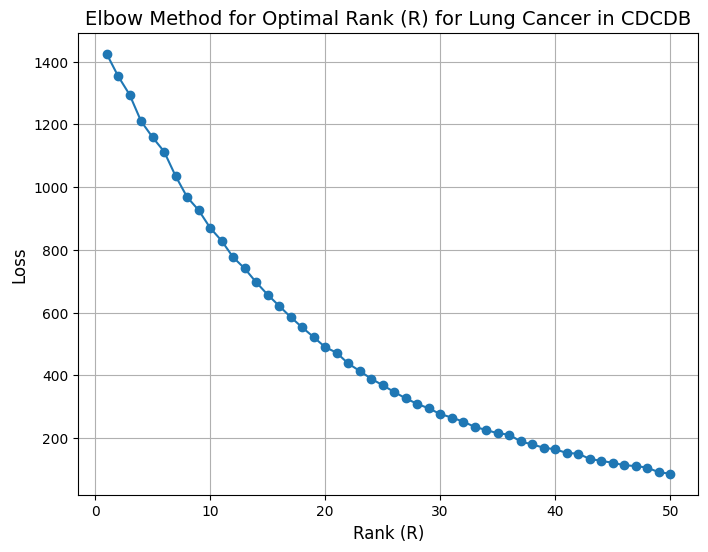

In [23]:
from tensorly.decomposition import parafac
from tensorly.tenalg import khatri_rao
import matplotlib.pyplot as plt

def cp_bp(tensor: np.ndarray, 
          R=1, 
          lr=1e-4, 
          max_iter=300,
          increase_factor=1.01,   
          decrease_factor=0.5,  
          verbose=True):

    
    N = tl.ndim(tensor)
    lbd, A = parafac(tensor, rank=R, init='random', random_state=0)
    old_loss = float('inf')

    for epoch in range(max_iter):

        tensor_pred = tl.fold(
            np.matmul(np.matmul(A[0], np.diag(lbd)), khatri_rao(A, skip_matrix=0).T),
            mode=0,
            shape=tensor.shape
        )
        

        theta = tensor - tensor_pred
        
        loss = 0.5 * np.sum(np.square(tl.unfold(theta, 0)))
        
        grad_A = []
        for n in range(N):
            grad_A.append(np.matmul(tl.unfold(theta, n), khatri_rao(A, skip_matrix=n)))

        A_backup = [np.copy(A[n]) for n in range(N)]  
        for n in range(N):
            A[n] = A[n] + lr * grad_A[n]

        tensor_pred_new = tl.fold(
            np.matmul(np.matmul(A[0], np.diag(lbd)), khatri_rao(A, skip_matrix=0).T),
            mode=0,
            shape=tensor.shape
        )
        theta_new = tensor - tensor_pred_new
        new_loss = 0.5 * np.sum(np.square(tl.unfold(theta_new, 0)))
        
        if new_loss > loss:
            for n in range(N):
                A[n] = A_backup[n]
            lr *= decrease_factor
            final_loss = loss  
        else:

            lr *= increase_factor
            final_loss = new_loss
        
        if verbose:
            print(f"epoch {epoch+1}/{max_iter} | lr = {lr:.6g} | loss = {final_loss:.6f}")

        old_loss = final_loss

    return A, lbd, final_loss

def find_optimal_rank(tensor, max_rank=30, max_iter=500, lr=1e-4):
    losses = []
    for R in range(1, max_rank + 1):
        print(f"\n===== Processing rank {R} =====")
        _, _, loss = cp_bp(tensor, R=R, lr=lr, max_iter=max_iter, verbose=False)
        print(f"[Rank={R}] final loss = {loss:.6f}")
        losses.append(loss)
    
    
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, max_rank + 1), losses, marker='o')
    plt.title('Elbow Method for Optimal Rank (R) for Lung Cancer in CDCDB', fontsize=14)
    plt.xlabel('Rank (R)', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.grid(True)
    plt.savefig(f"Elbow Method for Optimal Rank (R) for Lung Cancer in CDCDB.tiff", format="tiff", dpi=300, bbox_inches='tight')
    plt.show()
    return losses

if __name__ == '__main__':
    np.random.seed(10086)

    A, lbd, loss = cp_bp(
        tensor, 
        R=3, 
        lr=1e-5, 
        max_iter=50,
        increase_factor=1.01,  
        decrease_factor=0.5,   
        verbose=True
    )
    
    losses = find_optimal_rank(tensor, max_rank=50, max_iter=10, lr=1e-5)

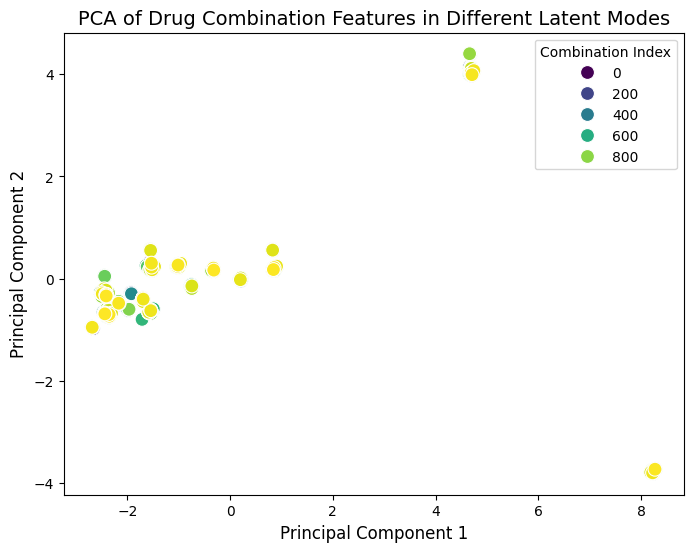

In [612]:

tensor = tl.tensor(score)
R = 25  
cp_tensor = parafac(tensor, rank=R)

all_combinations = np.dstack(np.unravel_index(np.argsort(tensor, axis=None), tensor.shape))[0]
unique_combinations = set()

for combination in all_combinations:
    sorted_combination = tuple(sorted(combination)) 

    if len(set(sorted_combination)) == 3:
        unique_combinations.add(sorted_combination)
    if len(unique_combinations) >= 1000:  
        break

features = []
combination_indices = list(unique_combinations)
for i, j, k in combination_indices:
    features.append(np.concatenate([
        cp_tensor.factors[0][i, :], 
        cp_tensor.factors[1][j, :],  
        cp_tensor.factors[2][k, :]   
    ]))

features = np.array(features)

pca = PCA(n_components=2)
features_2d = pca.fit_transform(features)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=features_2d[:, 0], y=features_2d[:, 1], hue=np.arange(len(features_2d)), palette="viridis", s=100)
plt.title("PCA of Drug Combination Features in Different Latent Modes", fontsize=14)
plt.xlabel("Principal Component 1", fontsize=12)
plt.ylabel("Principal Component 2", fontsize=12)
plt.legend(title="Combination Index")
plt.show()

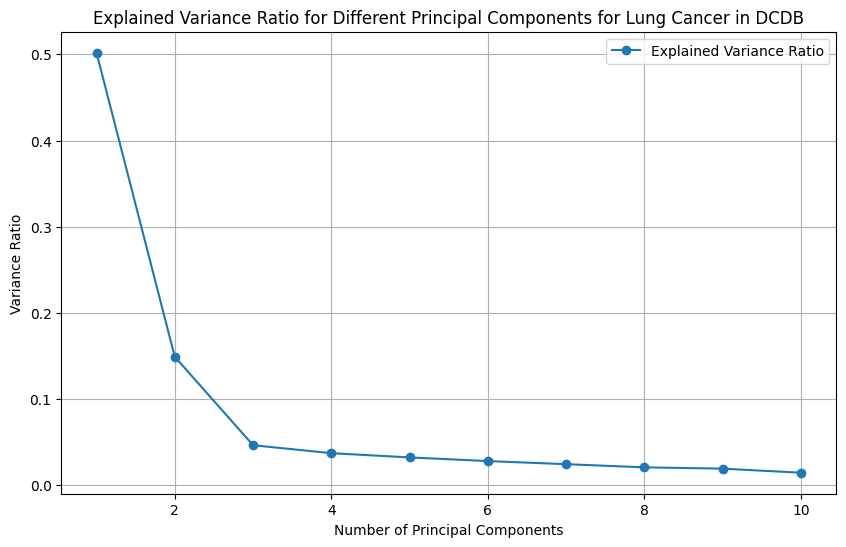

Principal Component 1: 0.5019 
Principal Component 2: 0.1490 
Principal Component 3: 0.0464 
Principal Component 4: 0.0371 
Principal Component 5: 0.0322 
Principal Component 6: 0.0280 
Principal Component 7: 0.0243 
Principal Component 8: 0.0207 
Principal Component 9: 0.0192 
Principal Component 10: 0.0144 


In [ ]:
num_pcs = 10 
pca = PCA(n_components=num_pcs)
features_pcs = pca.fit_transform(features)

explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

plt.figure(figsize=(10, 6))
plt.plot(range(1, num_pcs + 1), explained_variance_ratio, marker='o', label='Explained Variance Ratio')
plt.title("Explained Variance Ratio for Different Principal Components for Lung Cancer in DCDB")################################
plt.xlabel("Number of Principal Components")
plt.ylabel("Variance Ratio")
plt.legend()
plt.grid()
#plt.savefig(f"Explained Variance Ratio for Different Principal Components for Lung Cancer in DCDB.tiff", format="tiff", dpi=300, bbox_inches='tight')###########
plt.show()

for i, ratio in enumerate(explained_variance_ratio, start=1):
    print(f"Principal Component {i}: {ratio:.4f} ")
    #print(f"Principal Component {i}: {ratio:.4f} (Cumulative: {cumulative_variance[i-1]:.4f})")


In [614]:
R = 25  
cp_tensor = parafac(tensor, rank=R)

total_combinations = len(all_combinations)
top_10_percent = 1000  

for combination in all_combinations:
    sorted_combination = tuple(sorted(combination))  
    if len(set(sorted_combination)) == 3:  
        unique_combinations.add(sorted_combination)
    if len(unique_combinations) >= top_10_percent:  
        break


In [615]:
features = []
combination_indices = list(unique_combinations)
for i, j, k in combination_indices:
    features.append(np.concatenate([
        cp_tensor.factors[0][i, :],
        cp_tensor.factors[1][j, :],
        cp_tensor.factors[2][k, :]
    ]))
features = np.array(features)

pca = PCA(n_components=2)
features_2d = pca.fit_transform(features)

sse = []  
silhouette_scores = []  
K = range(2, 10)  


In [617]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score

import random
def silhouette_score_subsample(X, labels, subsample_size=1000):
    n = X.shape[0]
    if n > subsample_size:
        indices = random.sample(range(n), subsample_size)
        X_sub = X[indices]
        labels_sub = labels[indices]
        return silhouette_score(X_sub, labels_sub)
    else:
        return silhouette_score(X, labels)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(features_2d)
    sse.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score_subsample(features_2d, labels, subsample_size=1000))


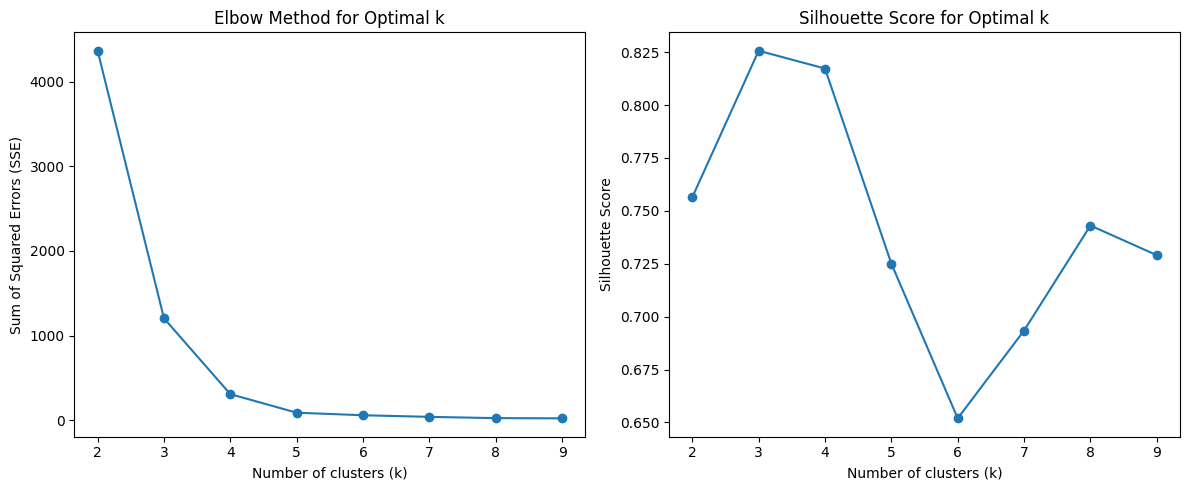

Optimal number of clusters (k): 3


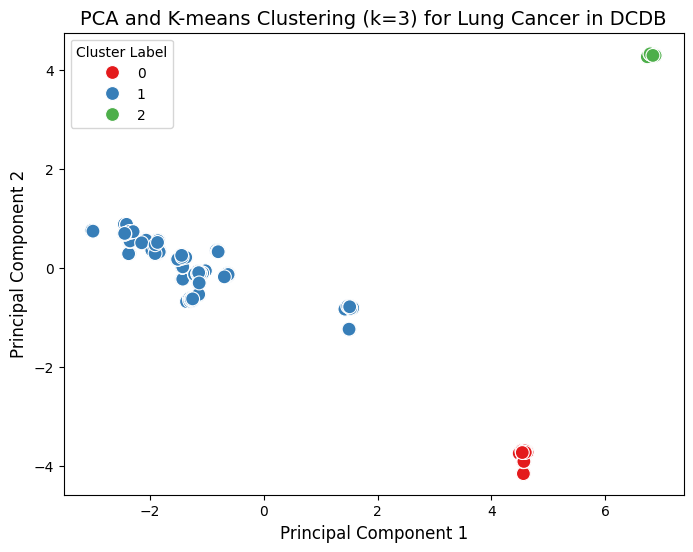

Cluster Labels and Combination Drug Names:
Combination 1: Drugs (Paclitaxel, Pemetrexed, Vandetanib), Cluster 1
Combination 2: Drugs (Docetaxel, Paclitaxel, Simvastatin), Cluster 2
Combination 3: Drugs (Capecitabine, Gefitinib, Paclitaxel), Cluster 1
Combination 4: Drugs (Etoposide, Paclitaxel, Vandetanib), Cluster 1
Combination 5: Drugs (Erlotinib, Gefitinib, Pemetrexed), Cluster 1
Combination 6: Drugs (Cisplatin, Gefitinib, Rosiglitazone), Cluster 1
Combination 7: Drugs (Bortezomib, Simvastatin, Vandetanib), Cluster 1
Combination 8: Drugs (Capecitabine, Oxaliplatin, Vandetanib), Cluster 1
Combination 9: Drugs (Bortezomib, Etoposide, Pemetrexed), Cluster 1
Combination 10: Drugs (Pemetrexed, Sorafenib, Vinorelbine), Cluster 1
Combination 11: Drugs (Afatinib, Oxaliplatin, Sorafenib), Cluster 1
Combination 12: Drugs (Carboplatin, Etoposide, Simvastatin), Cluster 0
Combination 13: Drugs (Afatinib, Carboplatin, Paclitaxel), Cluster 1
Combination 14: Drugs (Bortezomib, Irinotecan, Simvastat

In [618]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].plot(K, sse, marker='o')
ax[0].set_title("Elbow Method for Optimal k")
ax[0].set_xlabel("Number of clusters (k)")
ax[0].set_ylabel("Sum of Squared Errors (SSE)")

ax[1].plot(K, silhouette_scores, marker='o')
ax[1].set_title("Silhouette Score for Optimal k")
ax[1].set_xlabel("Number of clusters (k)")
ax[1].set_ylabel("Silhouette Score")

plt.tight_layout()
#plt.savefig(f"Elbow Method and Silhouette Score for Optimal k for Lung Cancer in DCDB.tiff", format="tiff", dpi=300, bbox_inches='tight')#################
plt.show()

optimal_k = K[np.argmax(silhouette_scores)]
print(f"Optimal number of clusters (k): {optimal_k}")

kmeans = KMeans(n_clusters=optimal_k, random_state=42)
labels = kmeans.fit_predict(features_2d)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=features_2d[:, 0], y=features_2d[:, 1], hue=labels, palette="Set1", s=100)
plt.title(f"PCA and K-means Clustering (k={optimal_k}) for Lung Cancer in DCDB", fontsize=14)#################################3########
plt.xlabel("Principal Component 1", fontsize=12)
plt.ylabel("Principal Component 2", fontsize=12)
plt.legend(title="Cluster Label")
#plt.savefig(f"PCA and K-means Clustering (k={optimal_k}) for Lung Cancer in DCDB.tiff", format="tiff", dpi=300, bbox_inches='tight')#####################
plt.show()


print("Cluster Labels and Combination Drug Names:")
for idx, (i, j, k) in enumerate(combination_indices):
    drug_i = drug_names[i]
    drug_j = drug_names[j]
    drug_k = drug_names[k]
    cluster_label = labels[idx]
    print(f"Combination {idx + 1}: Drugs ({drug_i}, {drug_j}, {drug_k}), Cluster {cluster_label}")

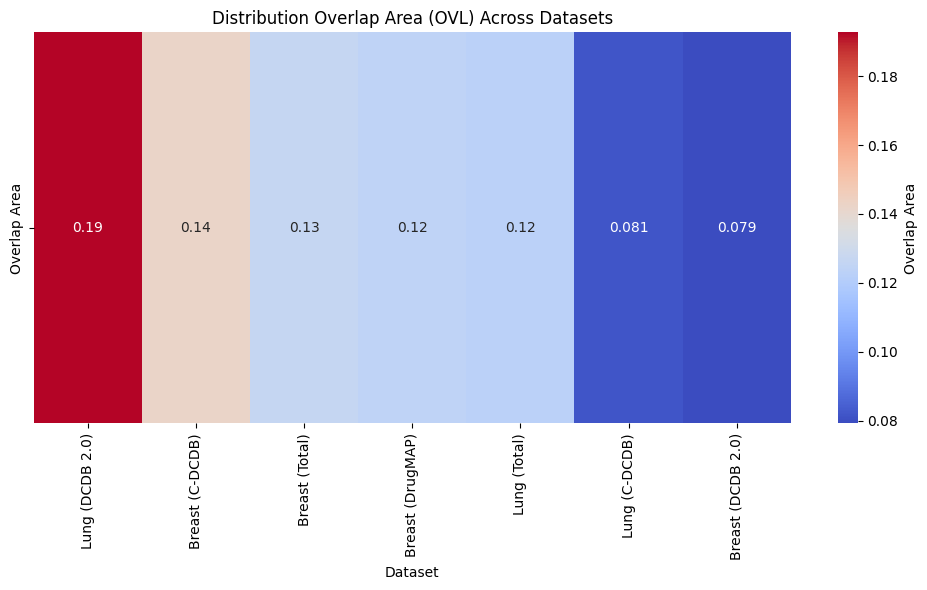

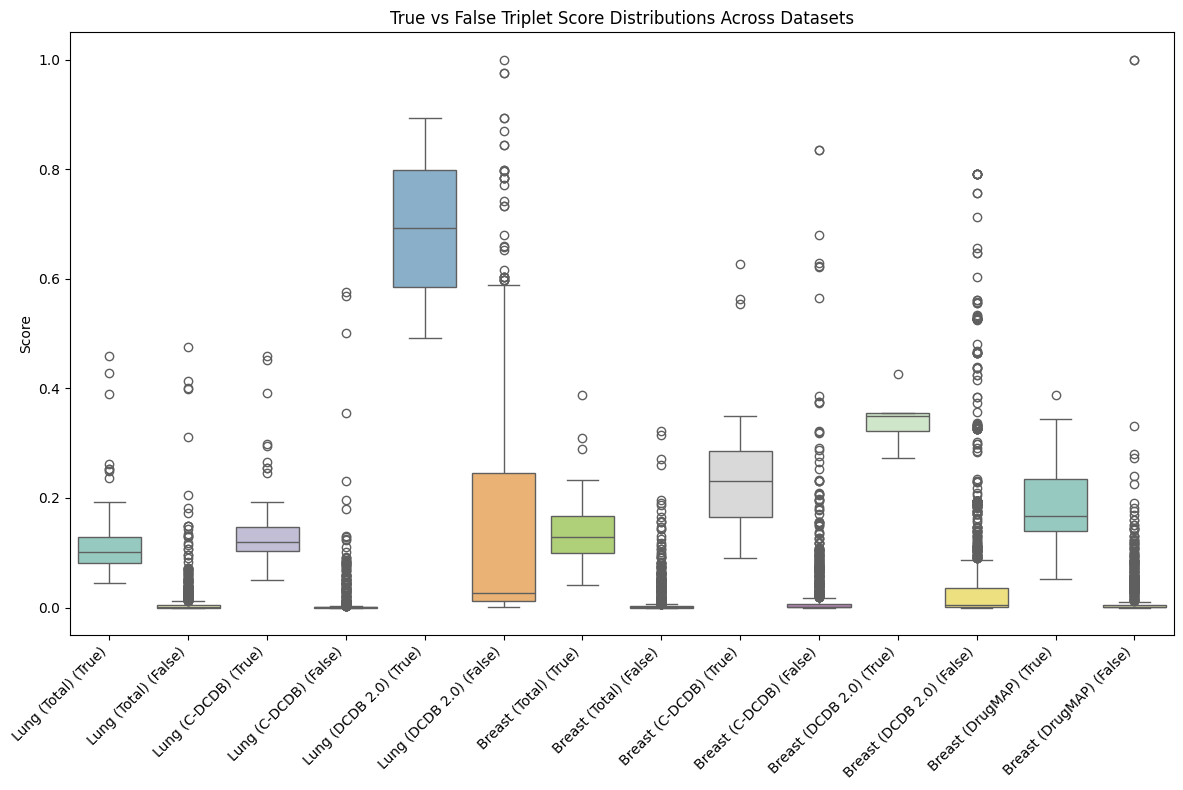

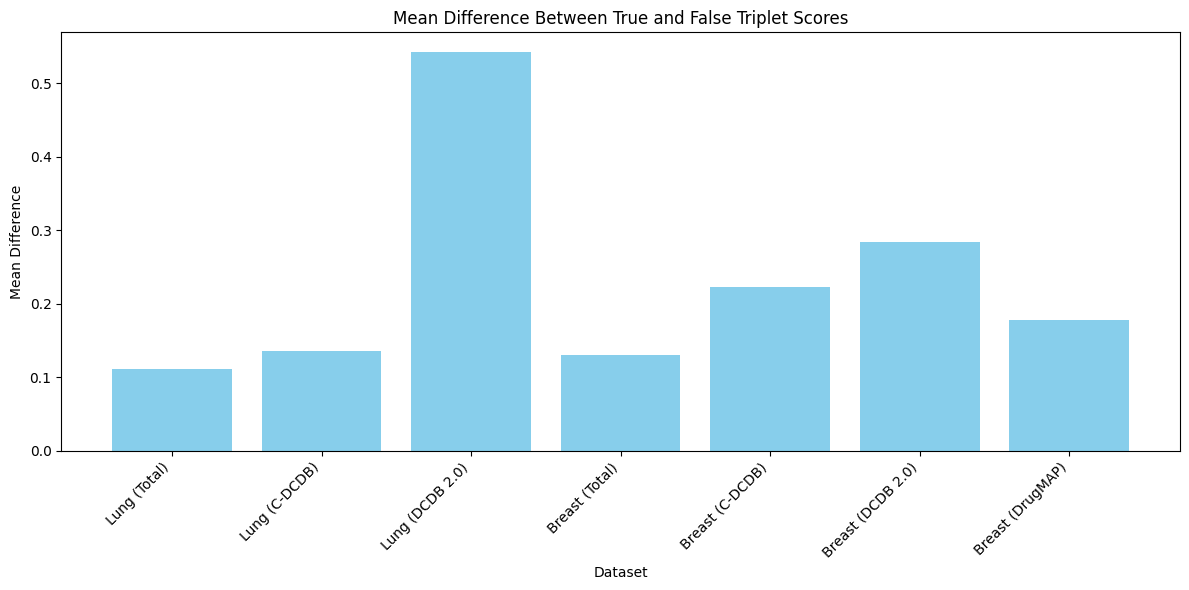

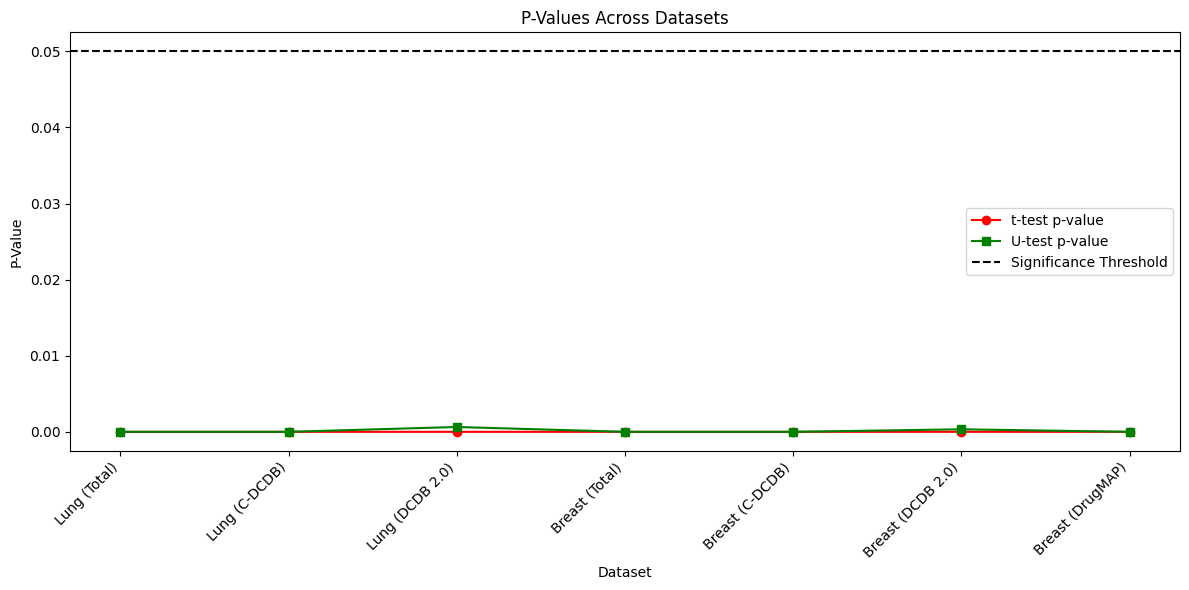

In [411]:
from scipy.stats import gaussian_kde, ttest_ind, mannwhitneyu

def extract_true_triplets(H, S):

    true_triplets = set()
    max_index = S.shape[0]  
    for edge_idx in range(H.shape[1]):
        nodes = np.where(H[:, edge_idx] == 1)[0]  
        if len(nodes) == 3 and all(node < max_index for node in nodes):  
            true_triplets.add(tuple(sorted(nodes))) 
    return true_triplets

def calculate_overlap_area(true_scores, false_scores):
    kde_true = gaussian_kde(true_scores)
    kde_false = gaussian_kde(false_scores)

    x = np.linspace(min(min(true_scores), min(false_scores)), 
                    max(max(true_scores), max(false_scores)), 1000)
    true_density = kde_true(x)
    false_density = kde_false(x)

    overlap_area = np.trapezoid(np.minimum(true_density, false_density), x)
    return overlap_area

def statistical_analysis(S, H, num_false_samples=1000):

    true_triplets = extract_true_triplets(H, S)  
    n = S.shape[0]
    true_scores = []
    false_scores = []

    for triplet in true_triplets:
        i, j, k = triplet
        if i < n and j < n and k < n:  
            true_scores.append(S[i, j, k])

    for _ in range(num_false_samples):
        while True:
            i, j, k = np.random.randint(0, n, size=3)
            if len(set((i, j, k))) == 3 and (i, j, k) not in true_triplets:
                false_scores.append(S[i, j, k])
                break

    true_scores = np.array(true_scores)
    false_scores = np.array(false_scores)

    
    t_stat, t_pvalue = ttest_ind(true_scores, false_scores, alternative='greater')
    u_stat, u_pvalue = mannwhitneyu(true_scores, false_scores, alternative='greater')
    mean_diff = np.mean(true_scores) - np.mean(false_scores)

    return true_scores, false_scores, mean_diff, t_pvalue, u_pvalue


def adjust_H(H, S):

    if H.shape[0] > S.shape[0]:
        H = H[:S.shape[0], :]  
    return H

datasets_results = {}
stat_results = {}

file_paths = [
    'Lung_155_Drug_Combination_Incidence_Matrix.csv',
    'Lung_CDCDB_119_270_Incidence_Matrix.csv',
    'Lung_DCDB_19_23_Incidence_Matrix.csv',
    'Breast_141_Drug_Combination_Incidence_Matrix.csv',
    'Breast_CDCDB_83_201_Incidence_Matrix.csv',
    'Breast_DCDB_30_35_Incidence_Matrix.csv',
    'Breast_drugmap_112_440_Incidence_Matrix.csv',
]

hyperedge_dfs = [pd.read_csv(file_path, index_col=0) for file_path in file_paths]
H_list = [df.values for df in hyperedge_dfs]

tensor_paths = [
    "lung_155_tensor2.npy",
    "lung_119_tensor2.npy",
    "lung_19_tensor2.npy",
    "breast_141_tensor2.npy",
    "breast_83_tensor2.npy",
    "breast_30_tensor2.npy",
    "breast_112_tensor2.npy",
]

S_list = [np.load(tensor_path) for tensor_path in tensor_paths]
dataset_names = [
        "Lung (Total)",
        "Lung (C-DCDB)",
        "Lung (DCDB 2.0)",
        "Breast (Total)",
        "Breast (C-DCDB)",
        "Breast (DCDB 2.0)",
        "Breast (DrugMAP)"
    ]

for i, (S, H) in enumerate(zip(S_list, H_list)):
    H = adjust_H(H, S)  
    true_scores, false_scores, mean_diff, t_pvalue, u_pvalue = statistical_analysis(S, H)
    datasets_results[dataset_names[i]] = (true_scores, false_scores)
    stat_results[dataset_names[i]] = (mean_diff, t_pvalue, u_pvalue)


plot_overlap_heatmap(datasets_results)  
plot_boxplot_combined(datasets_results)  
plot_statistical_summary(stat_results)  

In [412]:
def plot_combined_boxplot_with_stats(datasets_results, stat_results):

    data = []
    labels = []
    annotations = []  

    for dataset_name, (true_scores, false_scores) in datasets_results.items():
        data += [true_scores, false_scores]
        labels += [f"{dataset_name} (True)", f"{dataset_name} (False)"]

        mean_diff, t_pvalue, u_pvalue = stat_results[dataset_name]
        ovl = calculate_overlap_area(true_scores, false_scores)


        annotation = (
            f"Mean Diff: {mean_diff:.3f}\n"
            f"t-p: {t_pvalue:.1e}, U-p: {u_pvalue:.1e}\n"
            f"OVL: {ovl:.3f}"
        )
        annotations.append(annotation)

    plt.figure(figsize=(12, 8))
    ax = sns.boxplot(data=data, palette="Set3")
    plt.xticks(ticks=range(len(labels)), labels=labels, rotation=45, ha="right", fontsize=10)
    plt.title("True vs False Triplet Score Distributions with Statistics")
    plt.ylabel("Score")
    plt.xlabel("Datasets")

    for i in range(0, len(labels), 2):  
        x_pos = (i + i + 1) / 2  
        y_pos = max(max(data[i]), max(data[i + 1])) + 0.05  
        plt.text(x_pos, y_pos, annotations[i // 2], ha="center", fontsize=9, bbox=dict(facecolor="white", alpha=0.7))

    plt.tight_layout()
    #plt.savefig("Score_Distributions_with_Stats_Boxplot.tiff", format="tiff", dpi=300, bbox_inches="tight")
    plt.show()


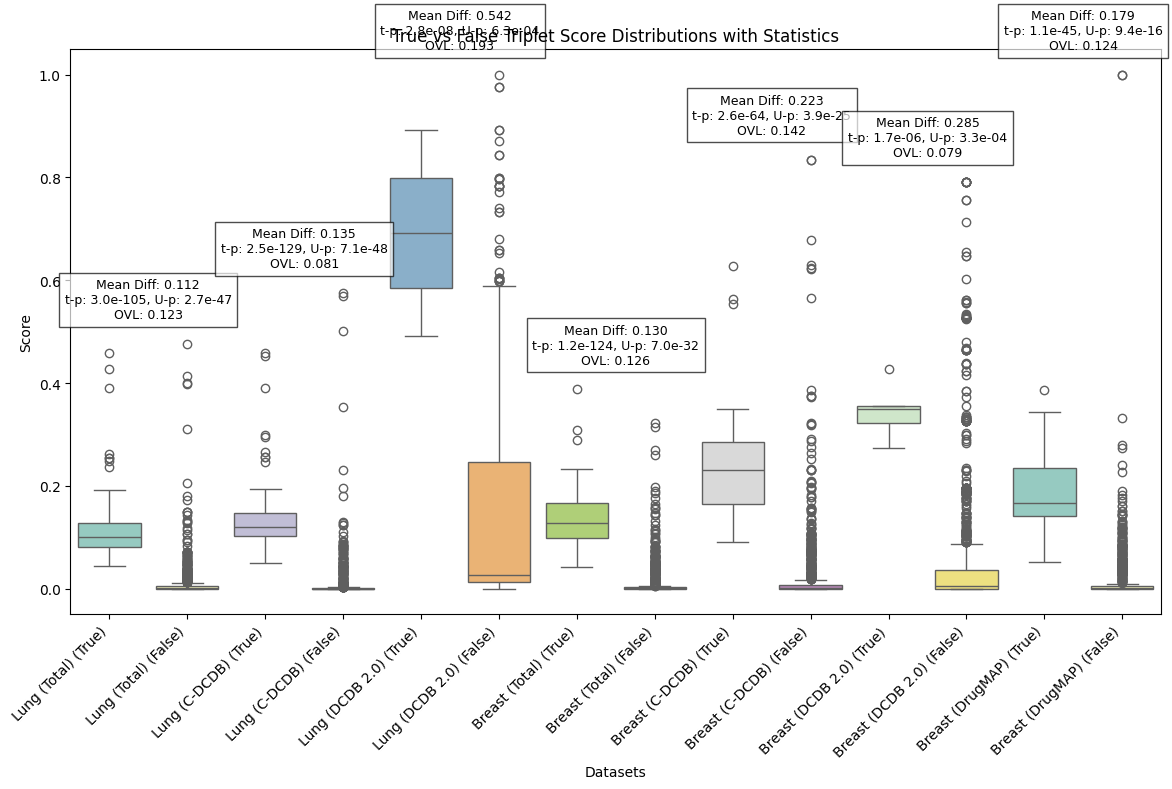

In [413]:
plot_combined_boxplot_with_stats(datasets_results, stat_results)


In [416]:
def plot_combined_boxplot_with_significance(datasets_results, stat_results):

    dataset_names = list(datasets_results.keys())
    mean_diffs = []
    ovls = []
    p_values = []
    
    data = []
    labels = []
    for dataset_name, (true_scores, false_scores) in datasets_results.items():
        data += [true_scores, false_scores]
        labels += [f"{dataset_name} (T)", f"{dataset_name} (F)"]
        
        mean_diff, t_pvalue, u_pvalue = stat_results[dataset_name]
        mean_diffs.append(mean_diff)
        ovl = calculate_overlap_area(true_scores, false_scores)
        ovls.append(ovl)
        p_values.append(min(t_pvalue, u_pvalue))

    fig, ax = plt.subplots(figsize=(12, 8))
    sns.boxplot(data=data, palette="Set3", ax=ax)
    plt.xticks(ticks=range(len(labels)), labels=labels, rotation=45, ha="right", fontsize=10)
    plt.title("Triplet Score Distributions: True vs False (with Significance)")
    plt.ylabel("Synergy Score")

    for i in range(0, len(labels), 2):  
        x1, x2 = i, i + 1  
        y, h = max(max(data[x1]), max(data[x2])) + 0.05, 0.02  
        p_value = p_values[i // 2]
        if p_value < 0.001:
            significance = '***'
        elif p_value < 0.01:
            significance = '**'
        elif p_value < 0.05:
            significance = '*'
        else:
            significance = 'ns'
        ax.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=1.5, color="black")  
        ax.text((x1 + x2) * 0.5, y + h, significance, ha='center', va='bottom', color="black", fontsize=10)

    plt.tight_layout()
    plt.savefig("Combined_Boxplot_with_Significance.tiff", format="tiff", dpi=300, bbox_inches='tight')
    plt.show()


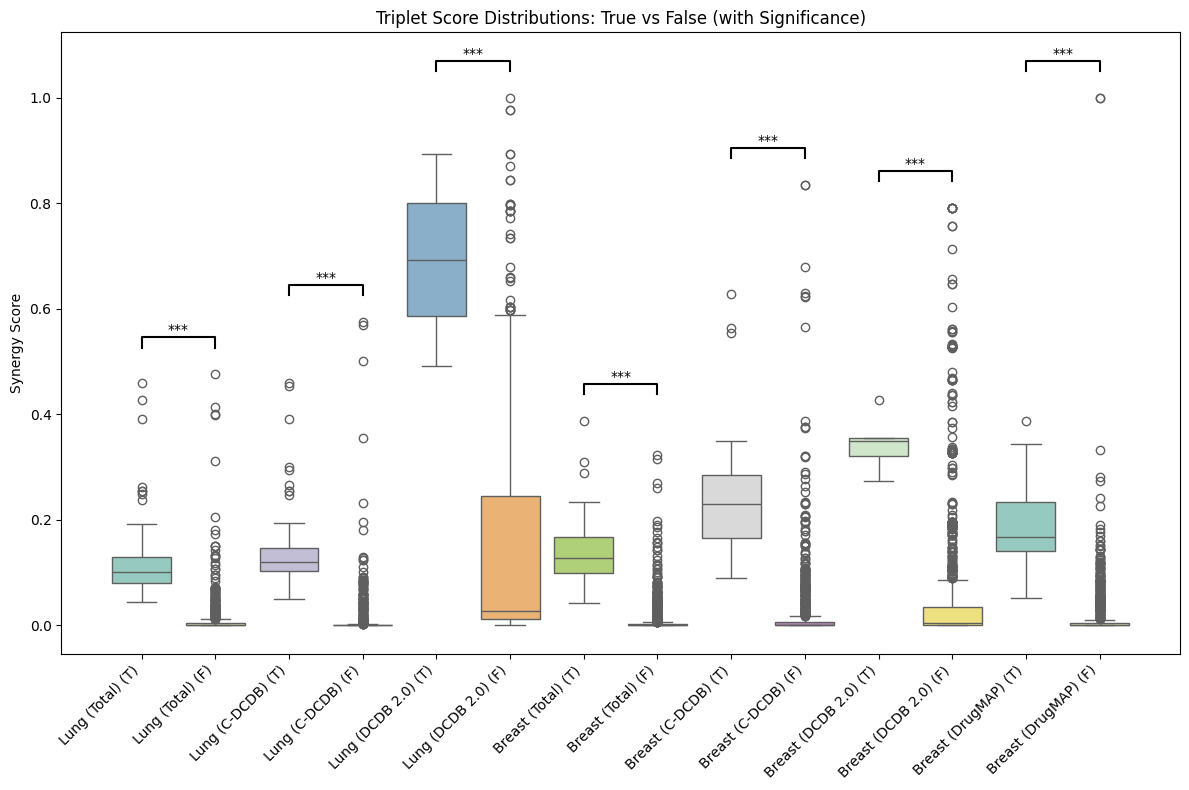

In [417]:
plot_combined_boxplot_with_significance(datasets_results, stat_results)